In [2]:
import numpy as np
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from scipy.spatial.distance import euclidean
embeddings = np.load('../russian_dict_cbow.npy', allow_pickle=True).item()
from ec_on_text import *
from features import *
from ordec import *
from ordec_borders import *
from trajectories import *
def split_text_into_chunks(text, chunk_size):
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

# jokes = [i for i in open('../anekdots_trunc.txt', 'r', encoding='utf-8').read().split('\n\n') if i != ''][0:100]
# liter = split_text_into_chunks(open('../pure_literature_trunc.txt', 'r', encoding='utf-8').read(), 25)[0:len(jokes)]

n_values = [2, 3, 4]
m_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
# m_values = [3, 4, 5, 6, 7, 8]
trajectories_jokes = {}
trajectories_liter = {}
results_jokes = {}
results_liter = {}

In [29]:
def get_embedding(lemma, embeddings):
    if lemma in embeddings:
        return embeddings[lemma]
    else:
        return None

def tokenize_and_find_bigrams(text):
    tokens = nltk.wordpunct_tokenize(text)
    finder = BigramCollocationFinder.from_words(tokens)
    return finder.nbest(BigramAssocMeasures().pmi, len(finder.ngram_fd))

def get_bigrams_with_embeddings(text, embeddings):
    bigrams = tokenize_and_find_bigrams(text)
    bigrams_with_embeddings = []
    for bigram in bigrams:
        emb1 = get_embedding(bigram[0], embeddings)
        emb2 = get_embedding(bigram[1], embeddings)
        if emb1 is not None and emb2 is not None:
            bigram_vector = np.concatenate((emb1, emb2))
            bigrams_with_embeddings.append(bigram_vector)
    return bigrams_with_embeddings

def calculate_euclidean_distances_between_bigrams(bigrams):
    distances = []
    for i in range(len(bigrams) - 1):
        bigram1 = bigrams[i]
        bigram2 = bigrams[i + 1]
        distance = euclidean(bigram1, bigram2)
        distances.append(distance)
    return distances

In [30]:
for m in m_values:
    trajectories_jokes[m] = []
    for joke in jokes:
        bigrams = get_bigrams_with_embeddings(joke, embeddings)
        distances = calculate_euclidean_distances_between_bigrams(bigrams)
        trajectories_jokes[m].append(distances)

    trajectories_liter[m] = []
    for lit in liter:
        bigrams = get_bigrams_with_embeddings(lit, embeddings)
        distances = calculate_euclidean_distances_between_bigrams(bigrams)
        trajectories_liter[m].append(distances)

In [31]:
for n in n_values:
    results_jokes[n] = {}
    for m in m_values:
        results_jokes[n][m] = []
        for trajectory in trajectories_jokes[m]:
            ent_comp = entropy_complexity(np.array(trajectory).reshape(-1, 1), n=n, m=m)
            results_jokes[n][m].append(ent_comp)

    results_liter[n] = {}
    for m in m_values:
        results_liter[n][m] = []
        for trajectory in trajectories_liter[m]:
            ent_comp = entropy_complexity(np.array(trajectory).reshape(-1, 1), n=n, m=m)
            results_liter[n][m].append(ent_comp)

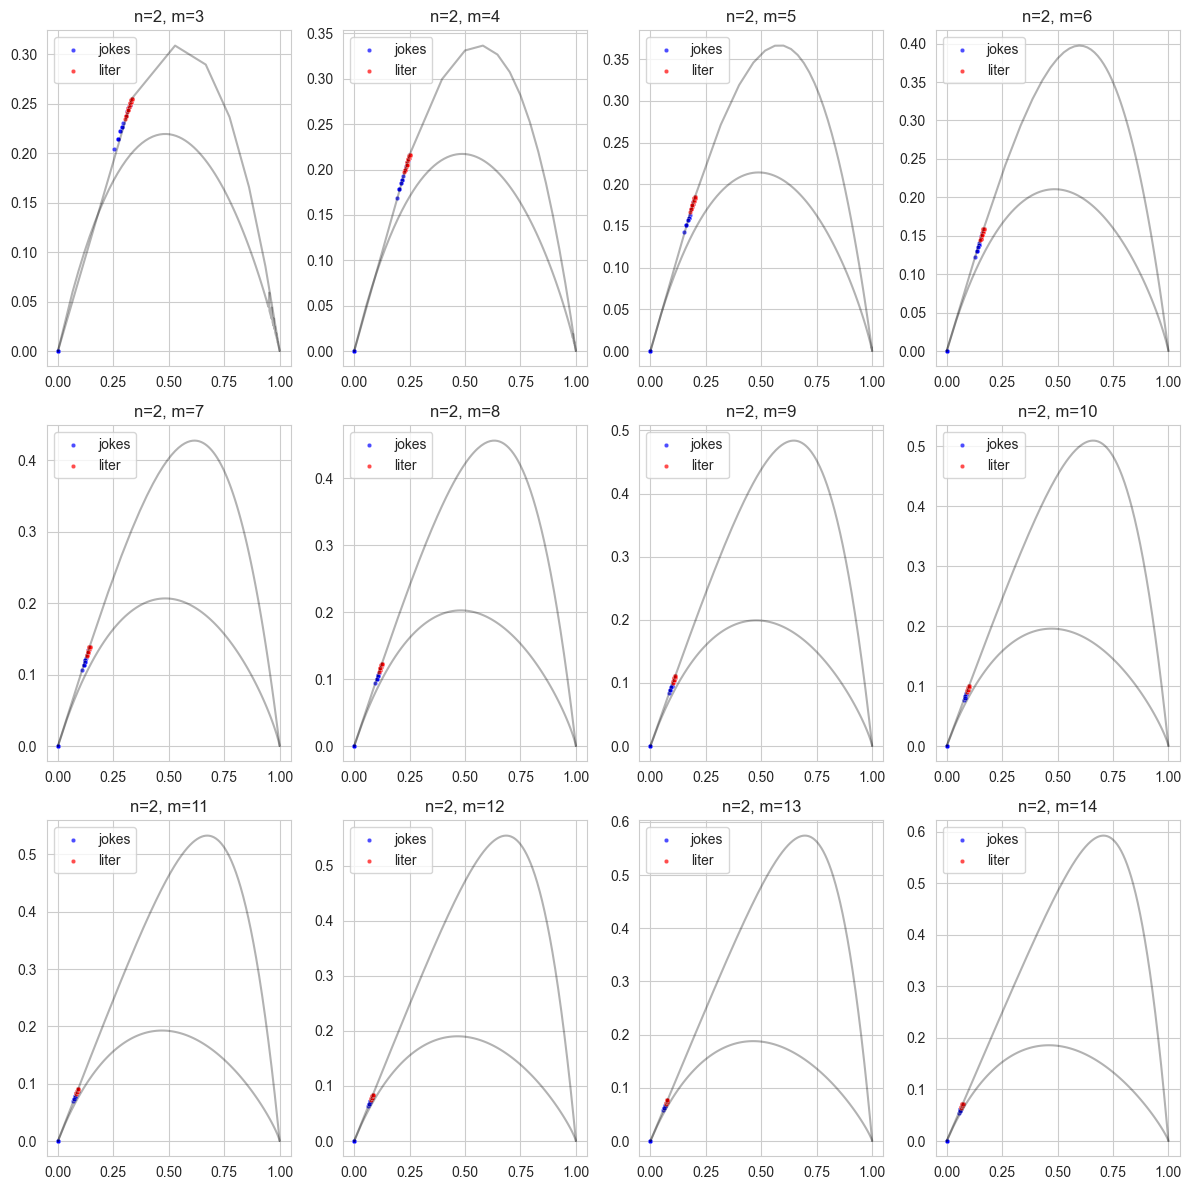

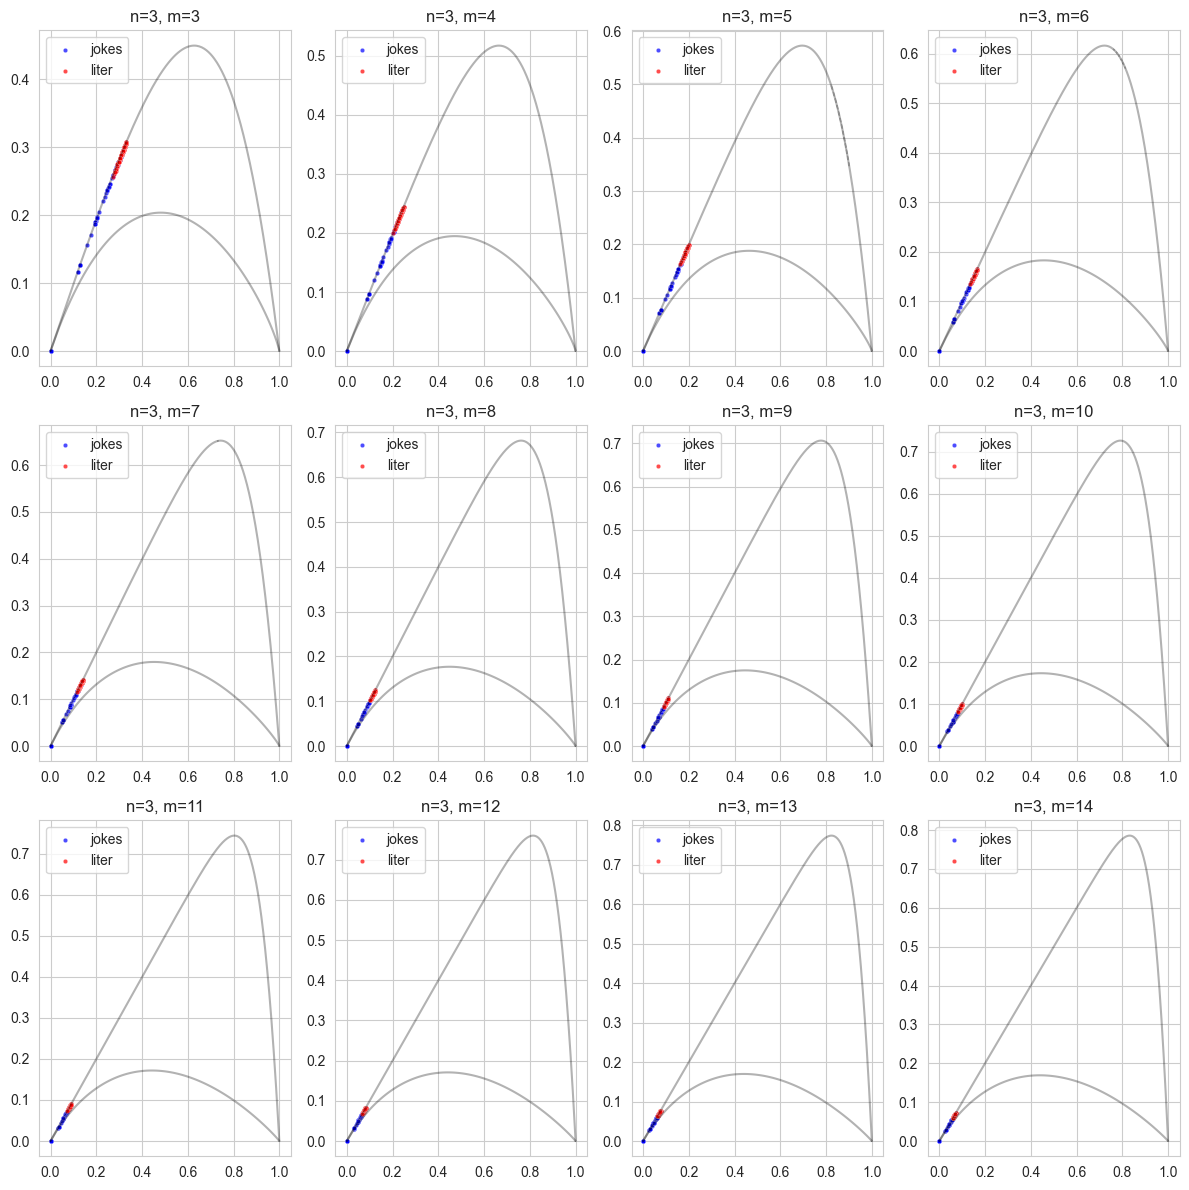

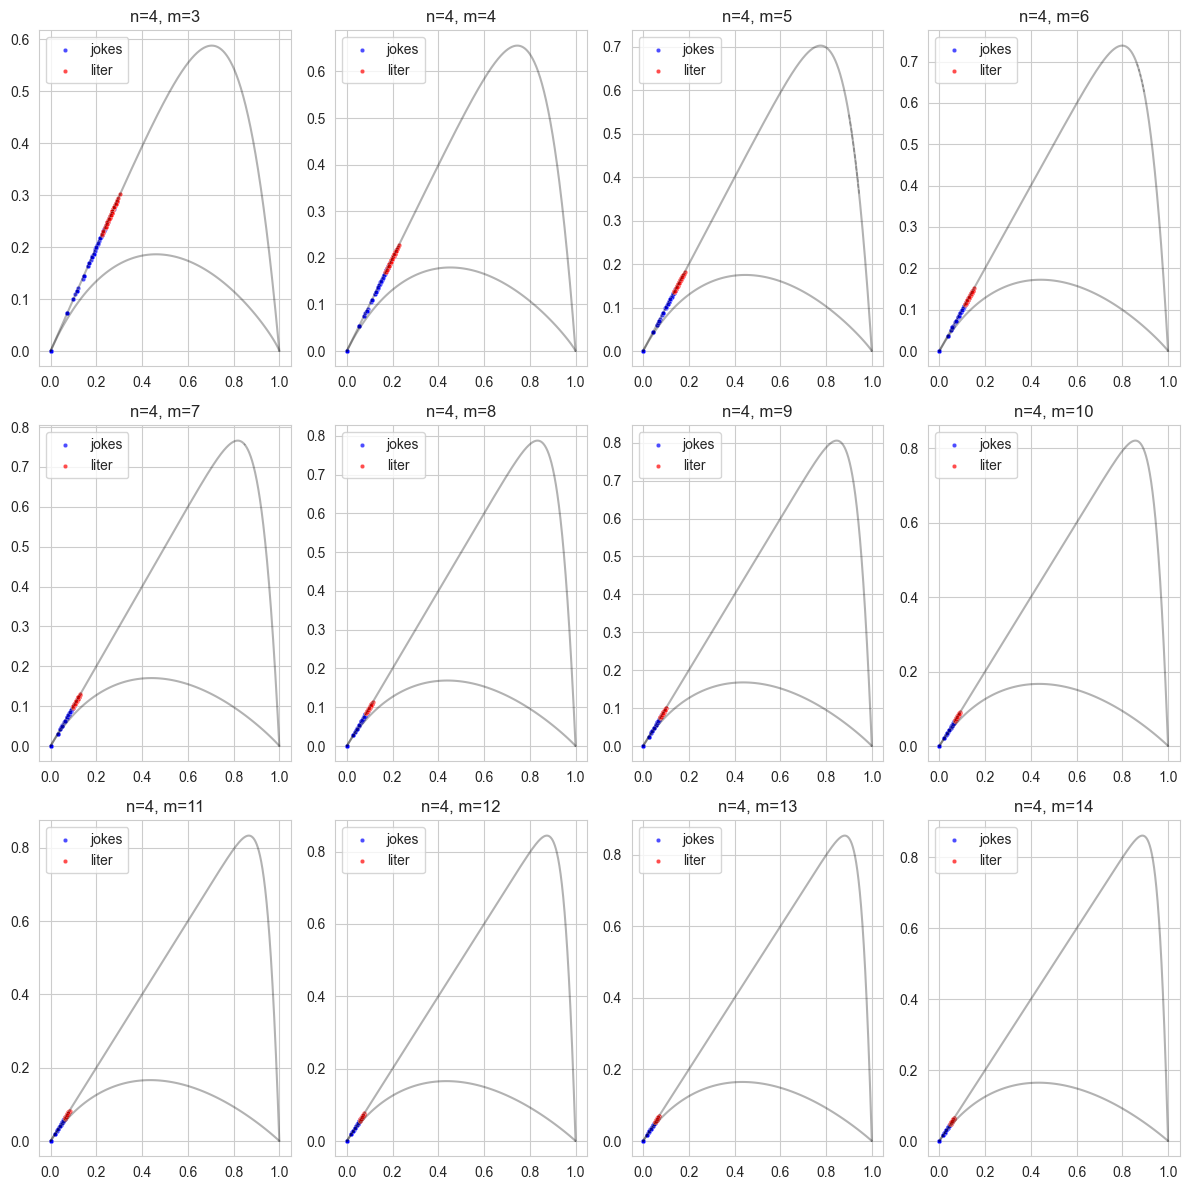

In [32]:
borders_precomp = {}
for n in n_values:
    for m in m_values:
        borders_precomp[(n, m)] = get_borders(n, m)

for n in n_values:
    fig, axes = plt.subplots(3, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for m_idx, m in enumerate(m_values):
        ax = axes[m_idx]

        min_ec, max_ec = borders_precomp[(n, m)]

        entropy_jokes = [x[0] for x in results_jokes[n][m]]
        complexity_jokes = [x[1] for x in results_jokes[n][m]]
        
        entropy_liter = [x[0] for x in results_liter[n][m]]
        complexity_liter = [x[1] for x in results_liter[n][m]]
        
        sns.scatterplot(
            x=entropy_jokes,
            y=complexity_jokes,
            color='blue',
            s=10,
            ax=ax,
            alpha=0.7,
            label='jokes'
        )
        
        sns.scatterplot(
            x=entropy_liter,
            y=complexity_liter,
            color='red',
            s=10,
            ax=ax,
            alpha=0.7,
            label='liter'
        )
        
        sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
        sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)
        
        ax.set_title(f"n={n}, m={m}")
        ax.legend()

    plt.tight_layout()
    plt.show()

По новой

In [49]:
import seaborn as sns
from itertools import permutations

def generate_z_vectors(y, size=5):
    zs = []
    for i in range(len(y)-size):
        zs.append(y[i:i+size])
    return np.array(zs)

def S(p):
    return -np.sum(p * np.log2(p + 10**(-13)))

def complexity_entropy(y, size=5):
    zs = generate_z_vectors(y, size)
    
    all_patterns = list(permutations(np.arange(size), r=size))
    freqs = np.zeros(len(all_patterns))
    n = len(all_patterns)
    
    patterns, counts = np.unique(np.argsort(zs, axis=1), return_counts=True, axis=0)
    
    for pattern, count in zip(patterns, counts):
        freqs[np.all(all_patterns == pattern, axis=1)] = count
    
    P = freqs / np.sum(freqs)
    Pe = np.full(n, 1 / n)
    
    Smax = np.log2(len(P))  # S(Pe)
    H = S(P) / Smax
    
    Jmax = -2 * (((n + 1) / n) * np.log2(n + 1) + np.log2(n) - 2 * np.log2(2 * n)) ** (-1)
    J = S((P + Pe) / 2) - S(P) / 2 - S(Pe) / 2
    
    C = J * H * Jmax
    
    return H, C

trajectories_jokes = {}
trajectories_liter = {}

for m in m_values:
    trajectories_jokes[m] = []
    for joke in jokes:
        bigrams = get_bigrams_with_embeddings(joke, embeddings)
        distances = calculate_euclidean_distances_between_bigrams(bigrams)
        trajectories_jokes[m].append(distances)

    trajectories_liter[m] = []
    for lit in liter:
        bigrams = get_bigrams_with_embeddings(lit, embeddings)
        distances = calculate_euclidean_distances_between_bigrams(bigrams)
        trajectories_liter[m].append(distances)

results_jokes = {}
results_liter = {}

for n in n_values:
    results_jokes[n] = {}
    results_liter[n] = {}
    for m in m_values:
        results_jokes[n][m] = []
        results_liter[n][m] = []
        for trajectory in trajectories_jokes[m]:
            ent_comp = complexity_entropy(trajectory, size=n)
            results_jokes[n][m].append(ent_comp)
        for trajectory in trajectories_liter[m]:
            ent_comp = complexity_entropy(trajectory, size=n)
            results_liter[n][m].append(ent_comp)

borders_precomp = {}
for n in n_values:
    for m in m_values:
        borders_precomp[(n, m)] = get_borders(n, m)

for n in n_values:
    fig, axes = plt.subplots(3, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for m_idx, m in enumerate(m_values):
        ax = axes[m_idx]

        min_ec, max_ec = borders_precomp[(n, m)]

        entropy_jokes = [x[0] for x in results_jokes[n][m]]
        complexity_jokes = [x[1] for x in results_jokes[n][m]]
        
        entropy_liter = [x[0] for x in results_liter[n][m]]
        complexity_liter = [x[1] for x in results_liter[n][m]]
        
        sns.scatterplot(
            x=entropy_jokes,
            y=complexity_jokes,
            color='blue',
            s=10,
            ax=ax,
            alpha=0.7,
            label='jokes'
        )
        
        sns.scatterplot(
            x=entropy_liter,
            y=complexity_liter,
            color='red',
            s=10,
            ax=ax,
            alpha=0.7,
            label='liter'
        )
        
        sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
        sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)
        
        ax.set_title(f"n={n}, m={m}")
        ax.legend()

    plt.tight_layout()
    plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

In [50]:
print(f"n={n}, m={m}:")
print("Jokes entropy:", entropy_jokes)
print("Jokes complexity:", complexity_jokes)
print("Literature entropy:", entropy_liter)
print("Literature complexity:", complexity_liter)

n=2, m=3:
Jokes entropy: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Jokes complexity: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

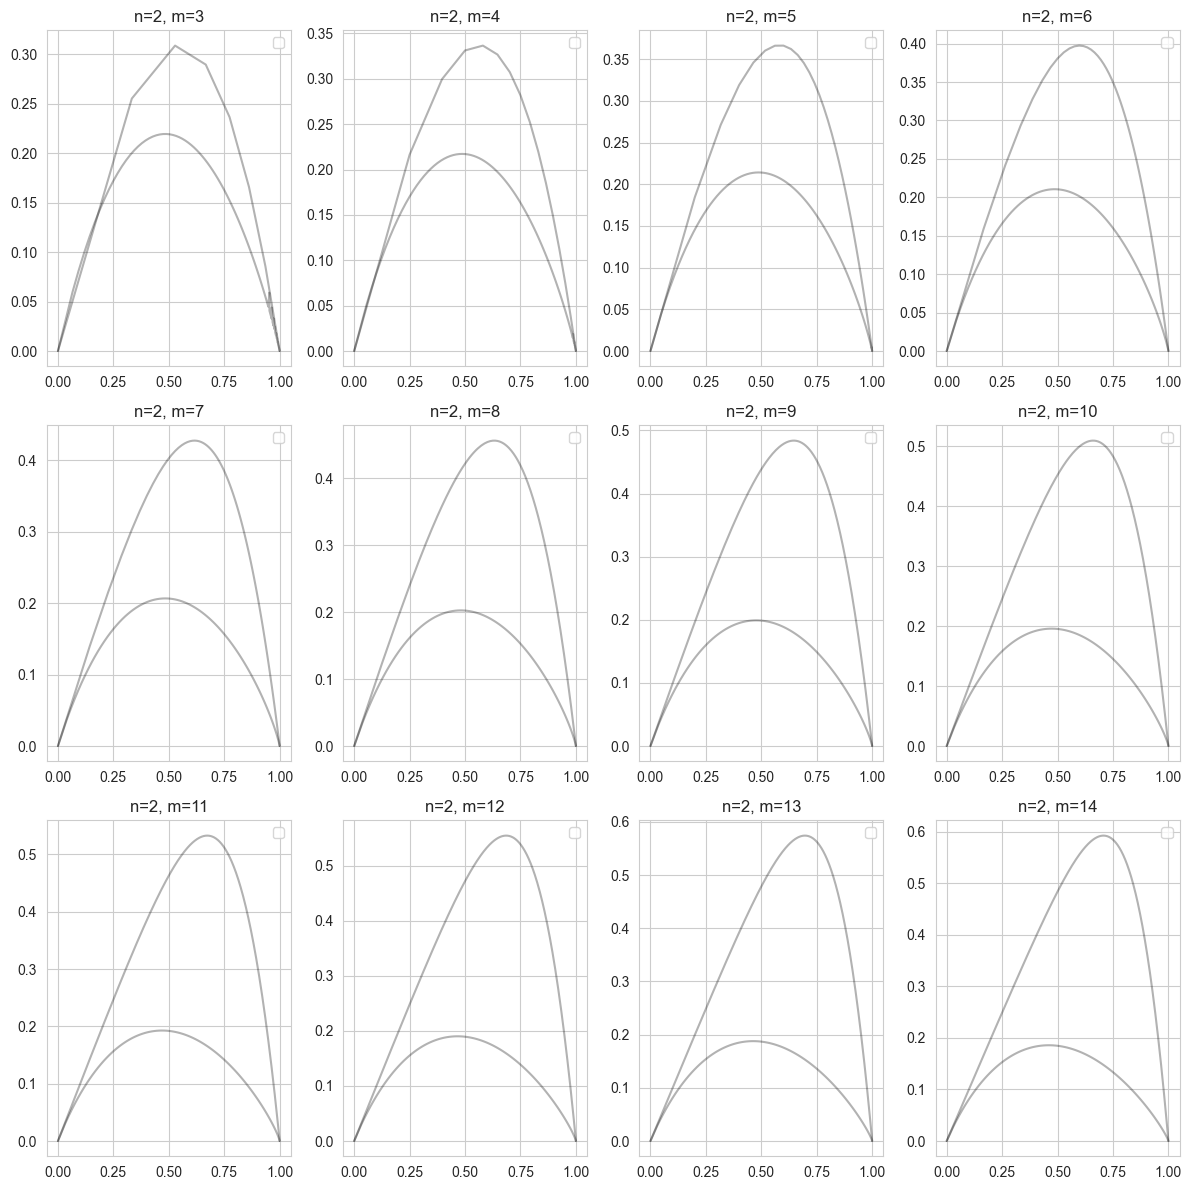

/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

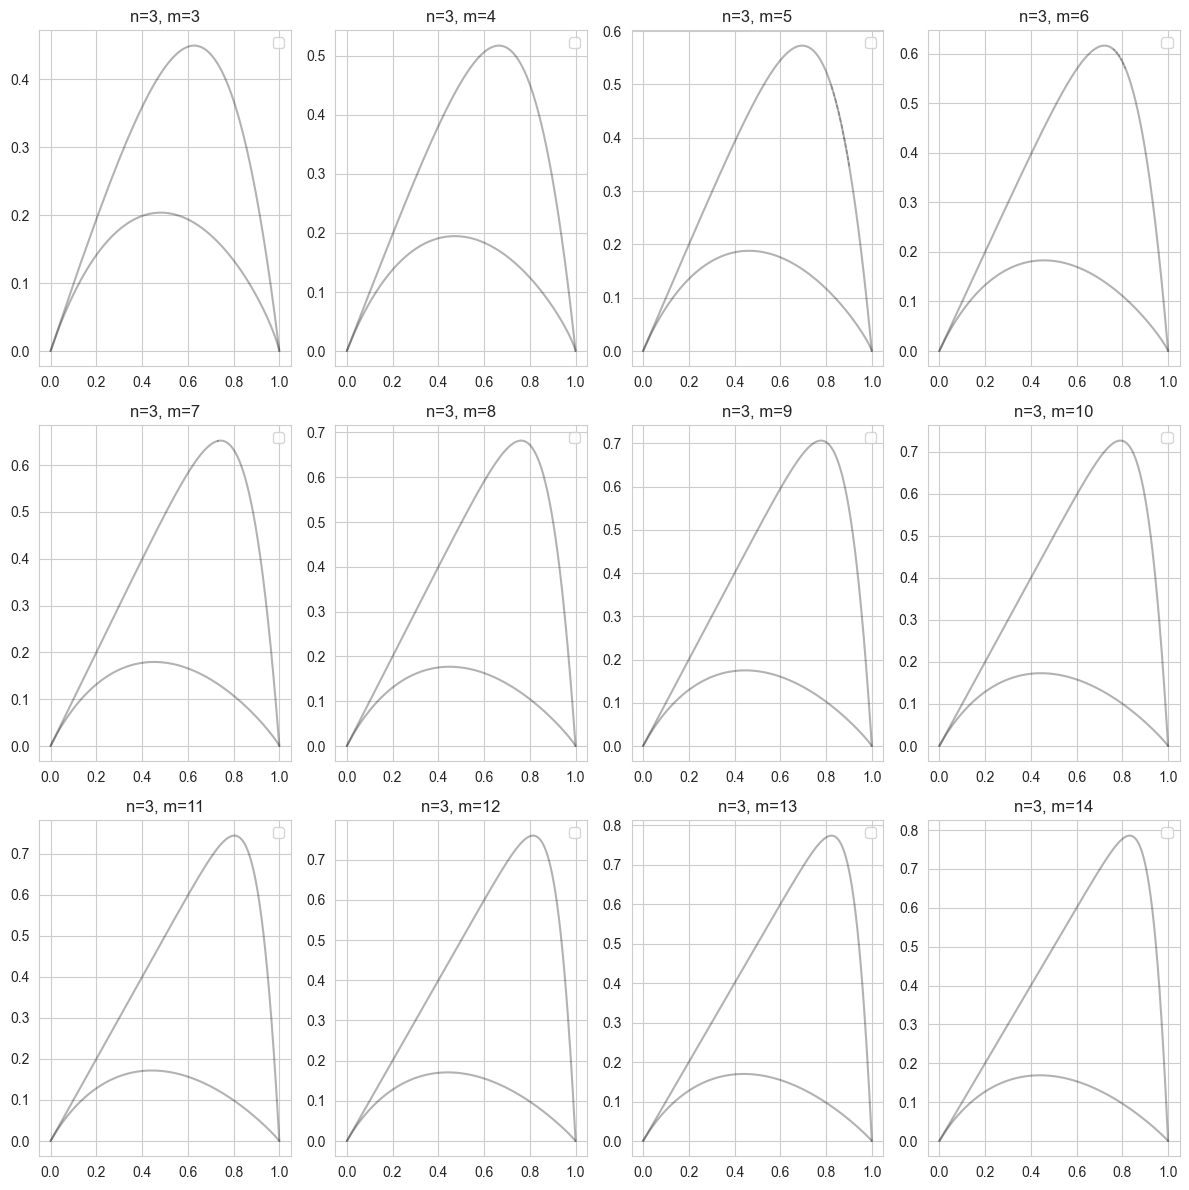

/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_36515/1226114736.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

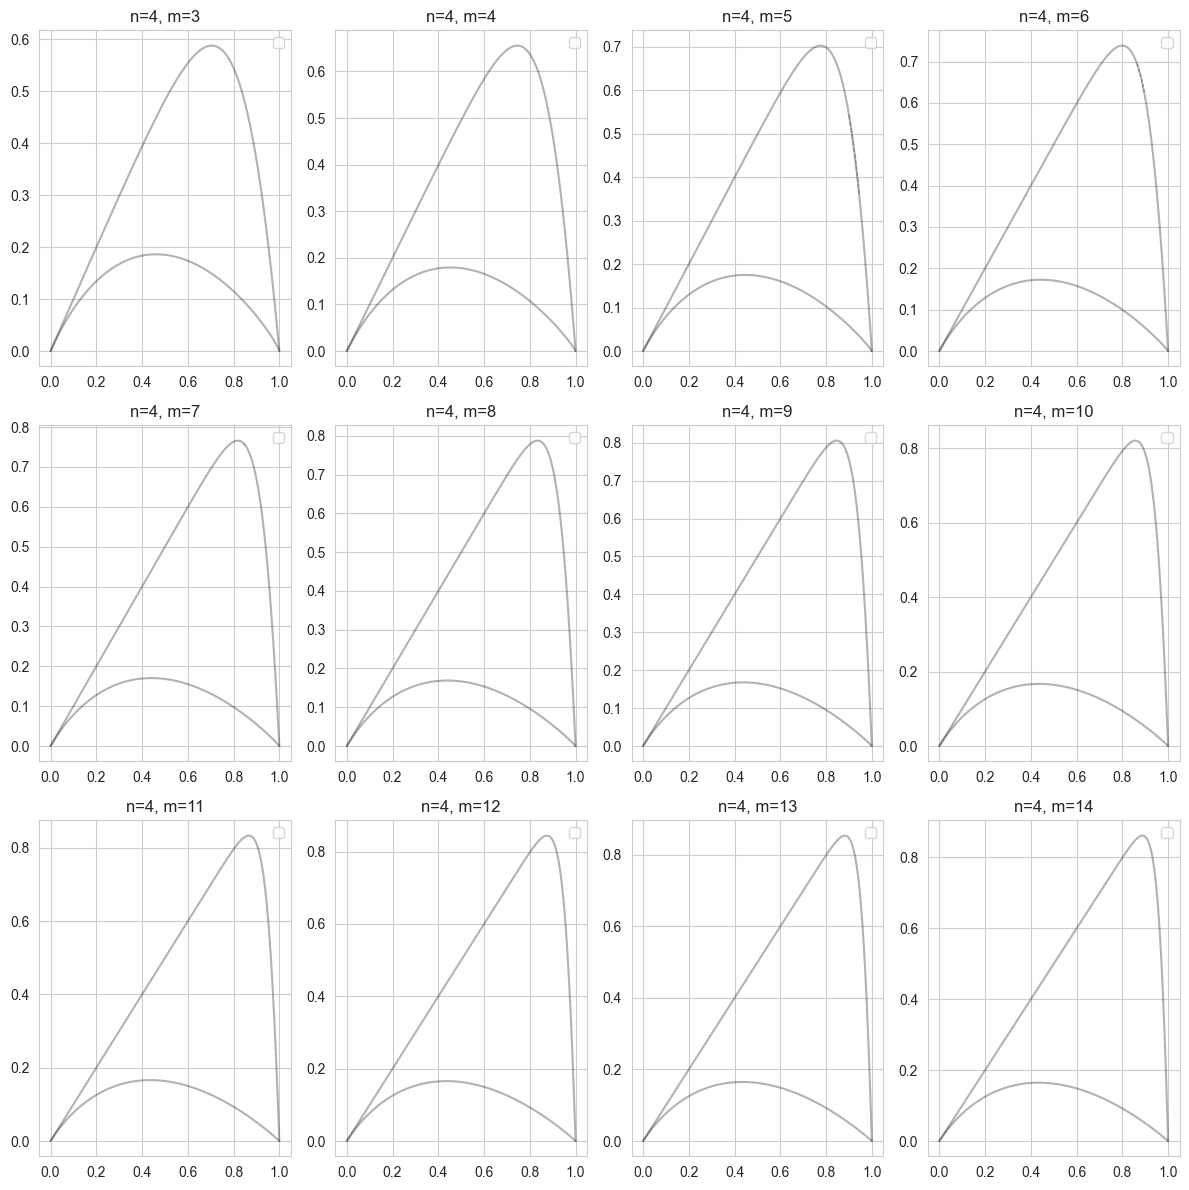

In [47]:
borders_precomp = {}
for n in n_values:
    for m in m_values:
        borders_precomp[(n, m)] = get_borders(n, m)

for n in n_values:
    fig, axes = plt.subplots(3, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    for m_idx, m in enumerate(m_values):
        ax = axes[m_idx]

        min_ec, max_ec = borders_precomp[(n, m)]

        entropy_jokes = [x[0] for x in results_jokes[n][m]]
        complexity_jokes = [x[1] for x in results_jokes[n][m]]
        
        entropy_liter = [x[0] for x in results_liter[n][m]]
        complexity_liter = [x[1] for x in results_liter[n][m]]
        
        sns.scatterplot(
            x=entropy_jokes,
            y=complexity_jokes,
            color='blue',
            s=10,
            ax=ax,
            alpha=0.7,
            label='jokes'
        )
        
        sns.scatterplot(
            x=entropy_liter,
            y=complexity_liter,
            color='red',
            s=10,
            ax=ax,
            alpha=0.7,
            label='liter'
        )
        
        sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
        sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)
        
        ax.set_title(f"n={n}, m={m}")
        ax.legend()

    plt.tight_layout()
    plt.show()

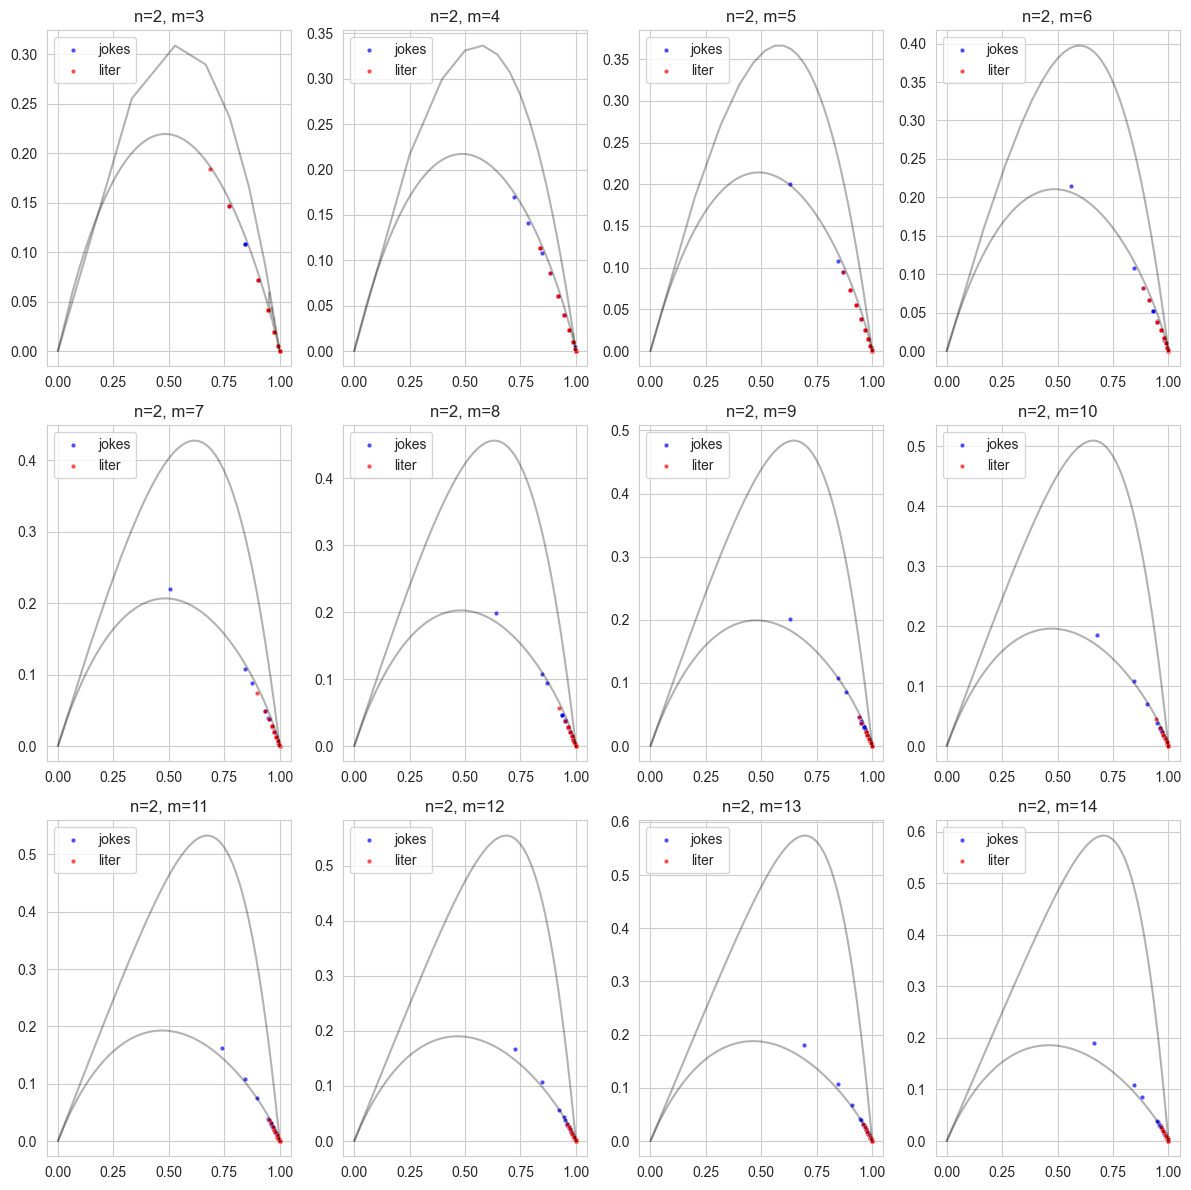

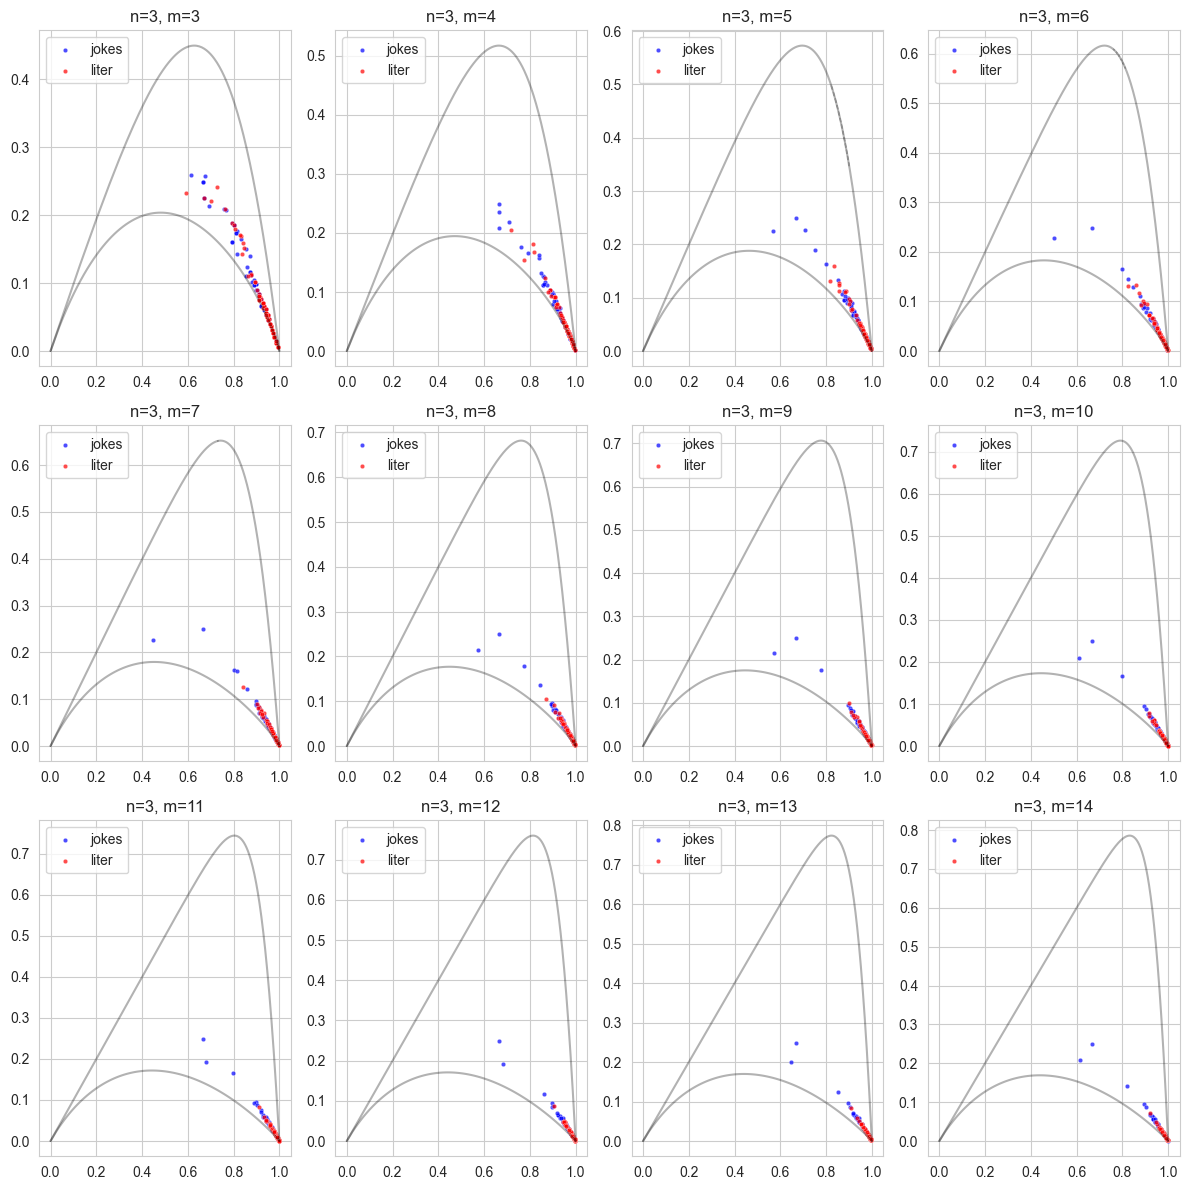

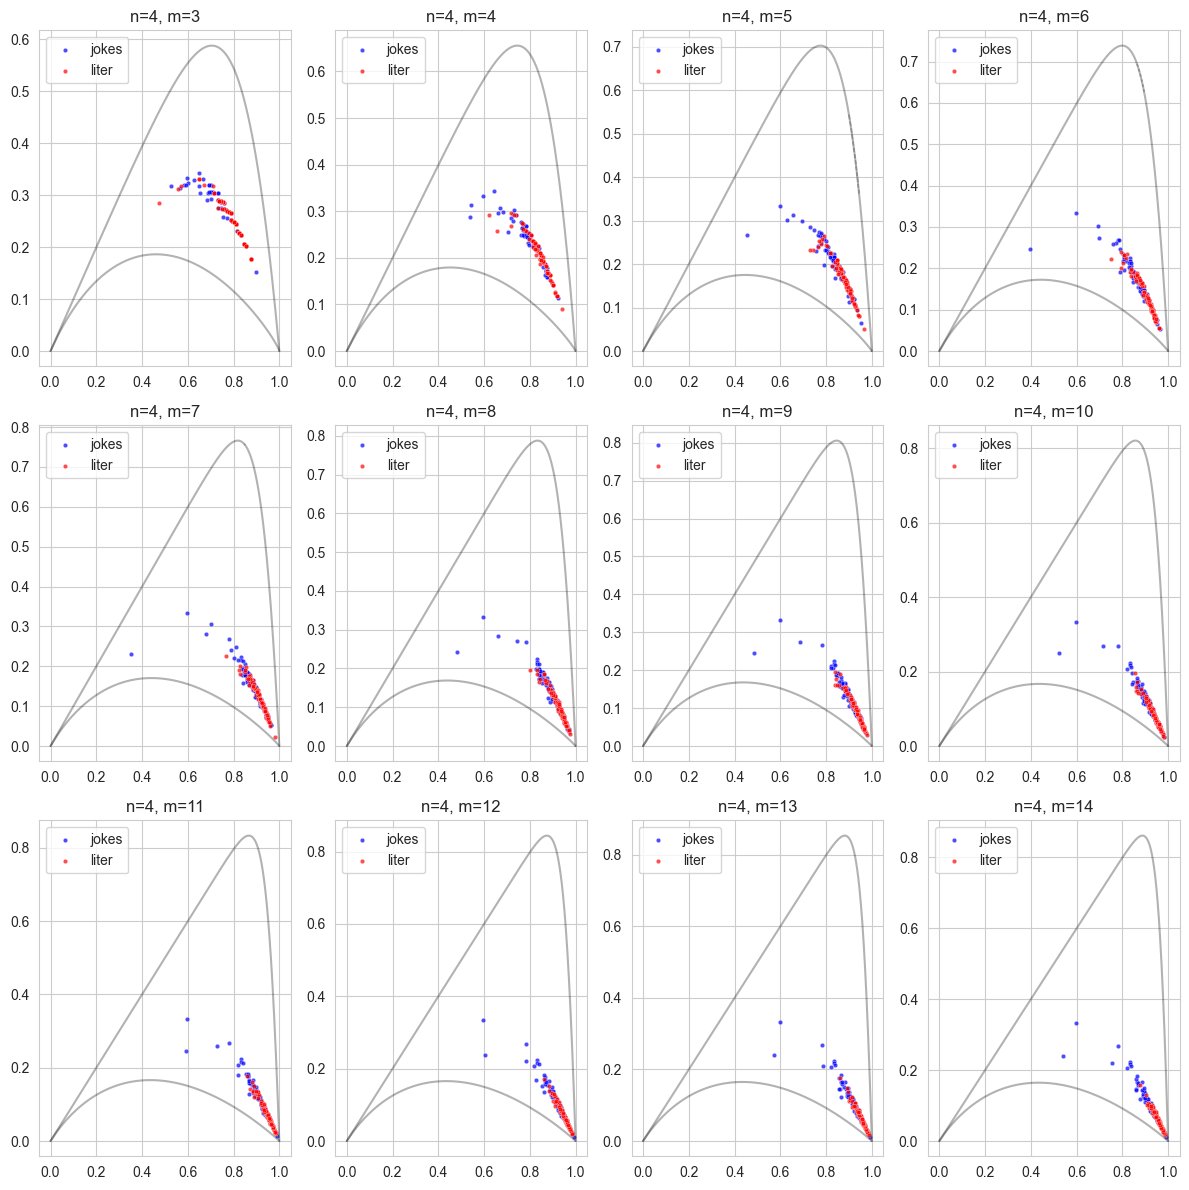

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
from scipy.spatial.distance import euclidean

def load_data():
    jokes = [i for i in open('../anekdots_trunc.txt', 'r', encoding='utf-8').read().split('\n\n') if i != ''][0:100]
    liter = split_text_into_chunks(open('../pure_literature_trunc.txt', 'r', encoding='utf-8').read(), 25)[0:len(jokes)]
    return jokes, liter

def split_text_into_chunks(text, chunk_size):
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

def text_to_trajectory(text, embeddings, m):
    words = text.split()
    trajectory = []
    for word in words:
        if word in embeddings:
            trajectory.append(embeddings[word])
        else:
            trajectory.append(np.zeros_like(list(embeddings.values())[0]))
    return np.array(trajectory[:m])

def generate_z_vectors(y, size=5):
    zs = []
    for i in range(len(y) - size):
        zs.append(y[i:i + size])
    return np.array(zs)

def complexity_entropy(y, size=5):
    zs = generate_z_vectors(y, size)

    all_patterns = list(permutations(np.arange(size), r=size))
    freqs = np.zeros(len(all_patterns))
    n = len(all_patterns)

    patterns, counts = np.unique(np.argsort(zs, axis=1), return_counts=True, axis=0)

    for pattern, count in zip(patterns, counts):
        freqs[np.all(all_patterns == pattern, axis=1)] = count

    P = freqs / np.sum(freqs)
    Pe = np.full(n, 1 / n)

    Smax = np.log2(len(P))  # S(Pe)
    H = S(P) / Smax

    Jmax = -2 * (((n + 1) / n) * np.log2(n + 1) + np.log2(n) - 2 * np.log2(2 * n)) ** (-1)
    J = S((P + Pe) / 2) - S(P) / 2 - S(Pe) / 2

    C = J * H * Jmax

    return H, C

def S(p):
    return -np.sum(p * np.log2(p + 10 ** (-13)))

def process_text_data(jokes, liter, embeddings, n_values, m_values):
    results_jokes = {}
    results_liter = {}

    for n in n_values:
        results_jokes[n] = {}
        results_liter[n] = {}
        for m in m_values:
            results_jokes[n][m] = []
            results_liter[n][m] = []
            for text in jokes:
                trajectory = text_to_trajectory(text, embeddings, m)
                ent_comp = complexity_entropy(trajectory.flatten(), size=n)
                results_jokes[n][m].append(ent_comp)
            for text in liter:
                trajectory = text_to_trajectory(text, embeddings, m)
                ent_comp = complexity_entropy(trajectory.flatten(), size=n)
                results_liter[n][m].append(ent_comp)

    return results_jokes, results_liter

def plot_results(results_jokes, results_liter, n_values, m_values, borders_precomp):
    for n in n_values:
        fig, axes = plt.subplots(3, 4, figsize=(12, 12))
        axes = axes.flatten()

        for m_idx, m in enumerate(m_values):
            ax = axes[m_idx]

            min_ec, max_ec = borders_precomp[(n, m)]

            entropy_jokes = [x[0] for x in results_jokes[n][m]]
            complexity_jokes = [x[1] for x in results_jokes[n][m]]

            entropy_liter = [x[0] for x in results_liter[n][m]]
            complexity_liter = [x[1] for x in results_liter[n][m]]

            sns.scatterplot(
                x=entropy_jokes,
                y=complexity_jokes,
                color='blue',
                s=10,
                ax=ax,
                alpha=0.7,
                label='jokes'
            )

            sns.scatterplot(
                x=entropy_liter,
                y=complexity_liter,
                color='red',
                s=10,
                ax=ax,
                alpha=0.7,
                label='liter'
            )

            sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
            sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)

            ax.set_title(f"n={n}, m={m}")
            ax.legend()

        plt.tight_layout()
        plt.show()

def main():
    jokes, liter = load_data()
    embeddings = np.load('../russian_dict_cbow.npy', allow_pickle=True).item()

    n_values = [2, 3, 4]
    m_values = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

    results_jokes, results_liter = process_text_data(jokes, liter, embeddings, n_values, m_values)

    borders_precomp = {}
    for n in n_values:
        for m in m_values:
            borders_precomp[(n, m)] = get_borders(n, m)

    plot_results(results_jokes, results_liter, n_values, m_values, borders_precomp)


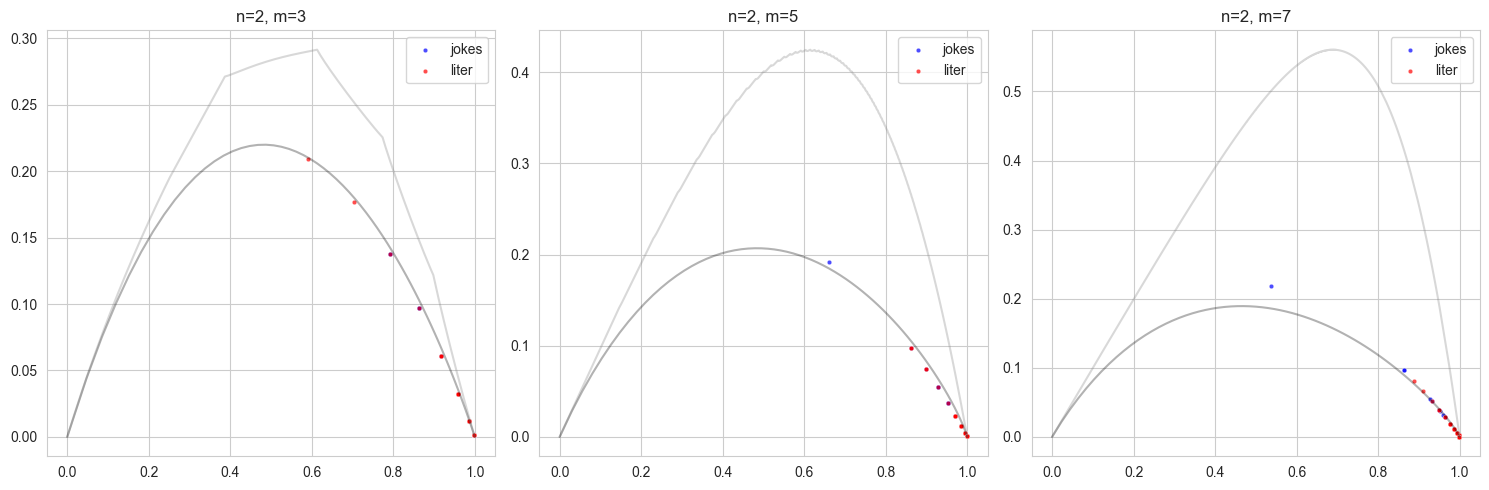

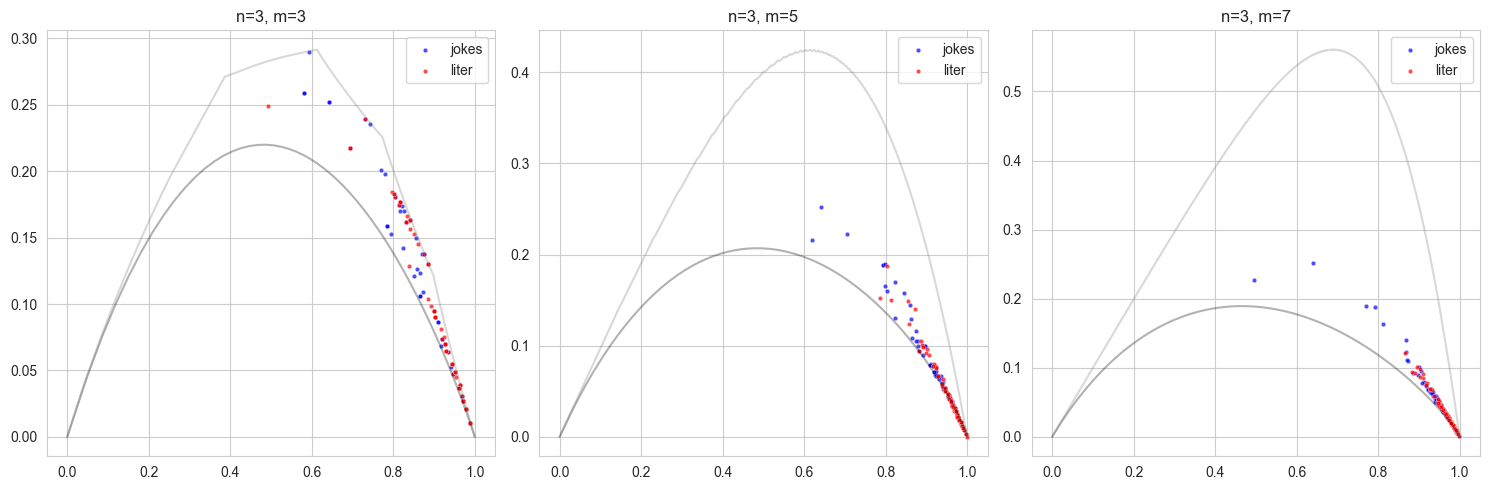

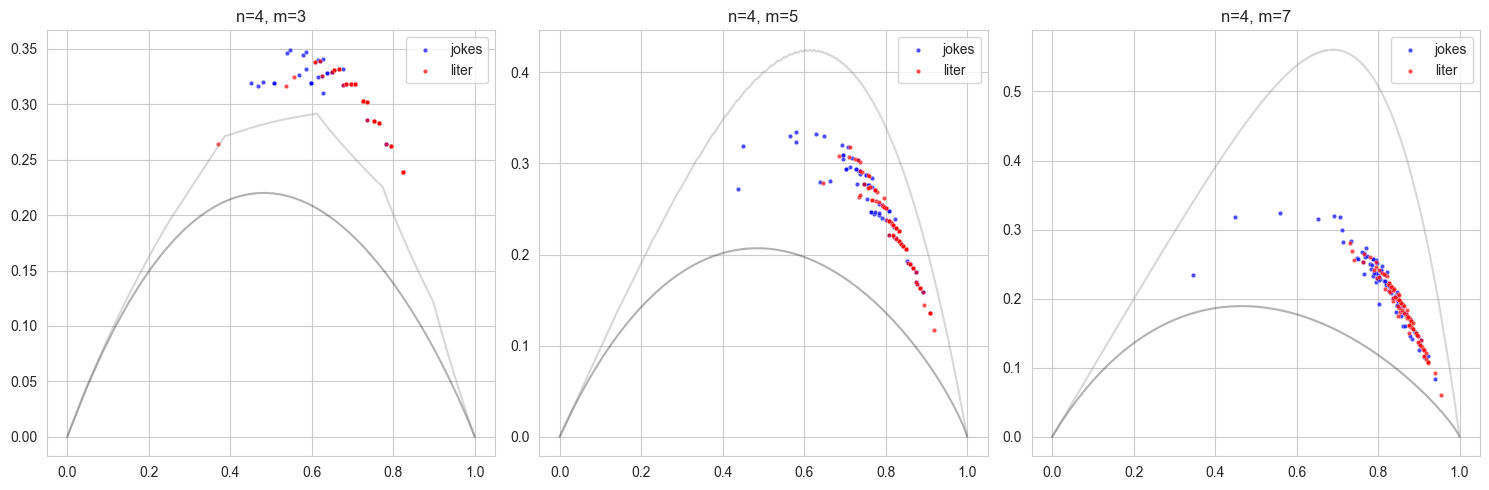

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ordpy import complexity_entropy, minimum_complexity_entropy, maximum_complexity_entropy

def load_data():
    jokes = [i for i in open('../anekdots_trunc.txt', 'r', encoding='utf-8').read().split('\n\n') if i != ''][0:100]
    liter = split_text_into_chunks(open('../pure_literature_trunc.txt', 'r', encoding='utf-8').read(), 25)[0:len(jokes)]
    return jokes, liter

def split_text_into_chunks(text, chunk_size):
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

def text_to_trajectory(text, embeddings, m):
    words = text.split()
    trajectory = []
    for word in words:
        if word in embeddings:
            trajectory.append(embeddings[word])
        else:
            trajectory.append(np.zeros_like(list(embeddings.values())[0]))
    return np.array(trajectory[:m])

def generate_z_vectors(y, size=5):
    zs = []
    for i in range(len(y) - size):
        zs.append(y[i:i + size])
    return np.array(zs)

def compute_complexity_entropy(y, dx=6):
    return complexity_entropy(y, dx=dx)

def process_text_data(jokes, liter, embeddings, n_values, m_values):
    results_jokes = {}
    results_liter = {}

    for n in n_values:
        results_jokes[n] = {}
        results_liter[n] = {}
        for m in m_values:
            results_jokes[n][m] = []
            results_liter[n][m] = []
            for text in jokes:
                trajectory = text_to_trajectory(text, embeddings, m)
                ent_comp = compute_complexity_entropy(trajectory, dx=n)
                results_jokes[n][m].append(ent_comp)
            for text in liter:
                trajectory = text_to_trajectory(text, embeddings, m)
                ent_comp = compute_complexity_entropy(trajectory, dx=n)
                results_liter[n][m].append(ent_comp)

    return results_jokes, results_liter

def plot_results(results_jokes, results_liter, n_values, m_values):
    for n in n_values:
        fig, axes = plt.subplots(1, len(m_values), figsize=(15, 5))
        if len(m_values) == 1:
            axes = [axes]
        axes = axes.flatten()

        for m_idx, m in enumerate(m_values):
            ax = axes[m_idx]

            min_ce = minimum_complexity_entropy(dx=m, size=70)
            max_ce = maximum_complexity_entropy(dx=m, m=70)

            entropy_jokes = [x[0] for x in results_jokes[n][m]]
            complexity_jokes = [x[1] for x in results_jokes[n][m]]

            entropy_liter = [x[0] for x in results_liter[n][m]]
            complexity_liter = [x[1] for x in results_liter[n][m]]

            sns.scatterplot(
                x=entropy_jokes,
                y=complexity_jokes,
                color='blue',
                s=10,
                ax=ax,
                alpha=0.7,
                label='jokes'
            )

            sns.scatterplot(
                x=entropy_liter,
                y=complexity_liter,
                color='red',
                s=10,
                ax=ax,
                alpha=0.7,
                label='liter'
            )

            sns.lineplot(x=min_ce[:, 0], y=min_ce[:, 1], color='black', ax=ax, alpha=0.3)
            sns.lineplot(x=max_ce[:, 0], y=max_ce[:, 1], color='gray', ax=ax, alpha=0.3)

            ax.set_title(f"n={n}, m={m}")
            ax.legend()

        plt.tight_layout()
        plt.show()

def main():
    jokes, liter = load_data()
    embeddings = np.load('../russian_dict_cbow.npy', allow_pickle=True).item()

    n_values = [2, 3, 4]
    m_values = [3, 5, 7]

    results_jokes, results_liter = process_text_data(jokes, liter, embeddings, n_values, m_values)

    plot_results(results_jokes, results_liter, n_values, m_values)

if __name__ == "__main__":
    main()

/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

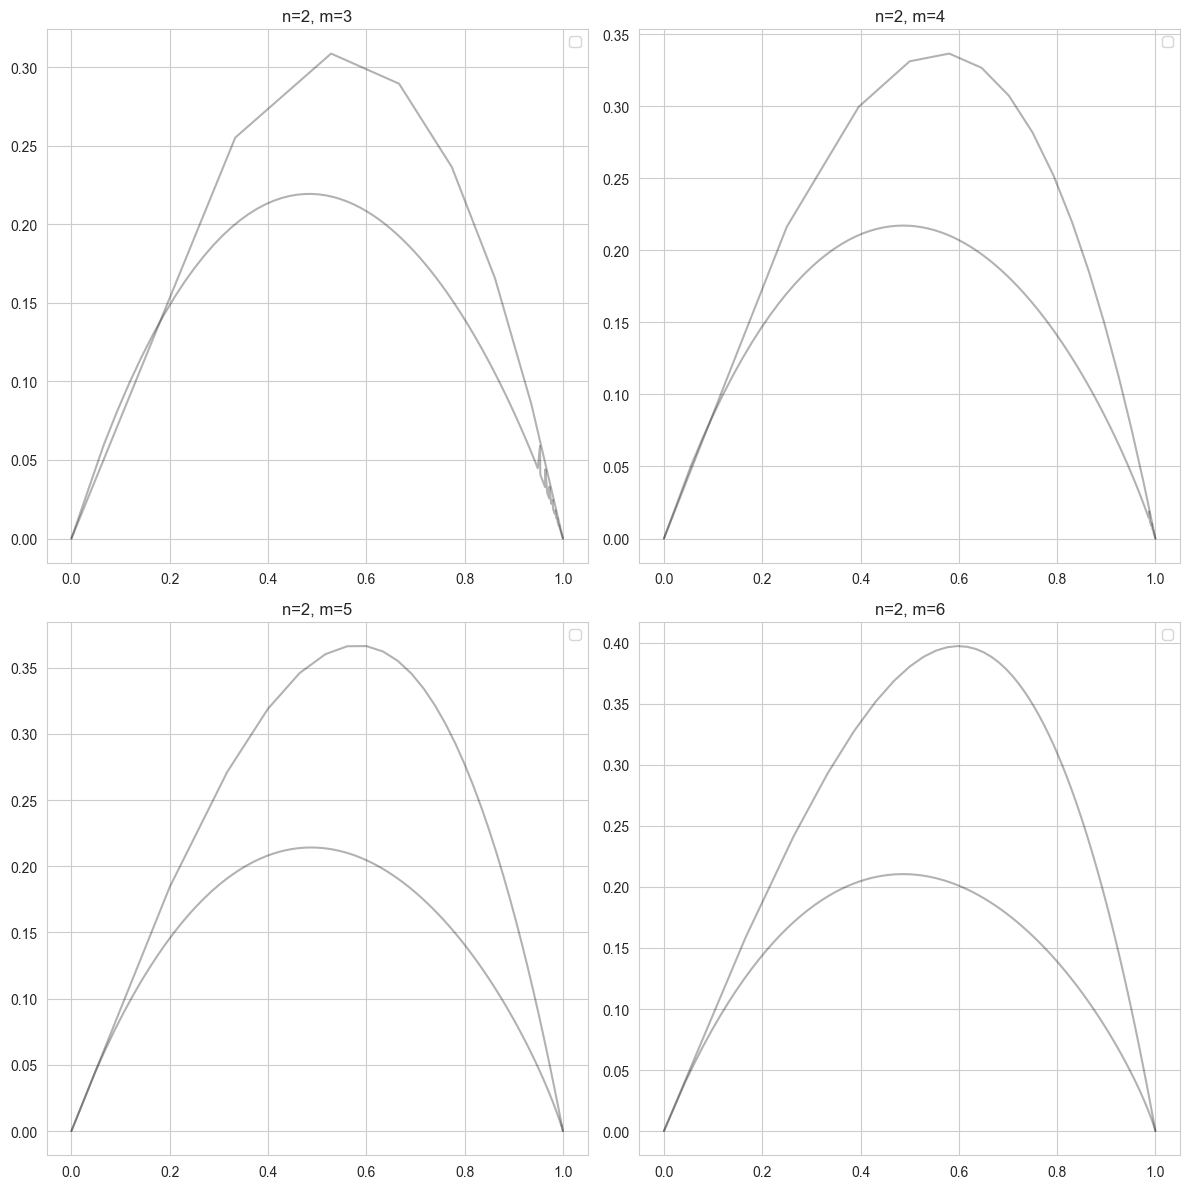

/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3975093700.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

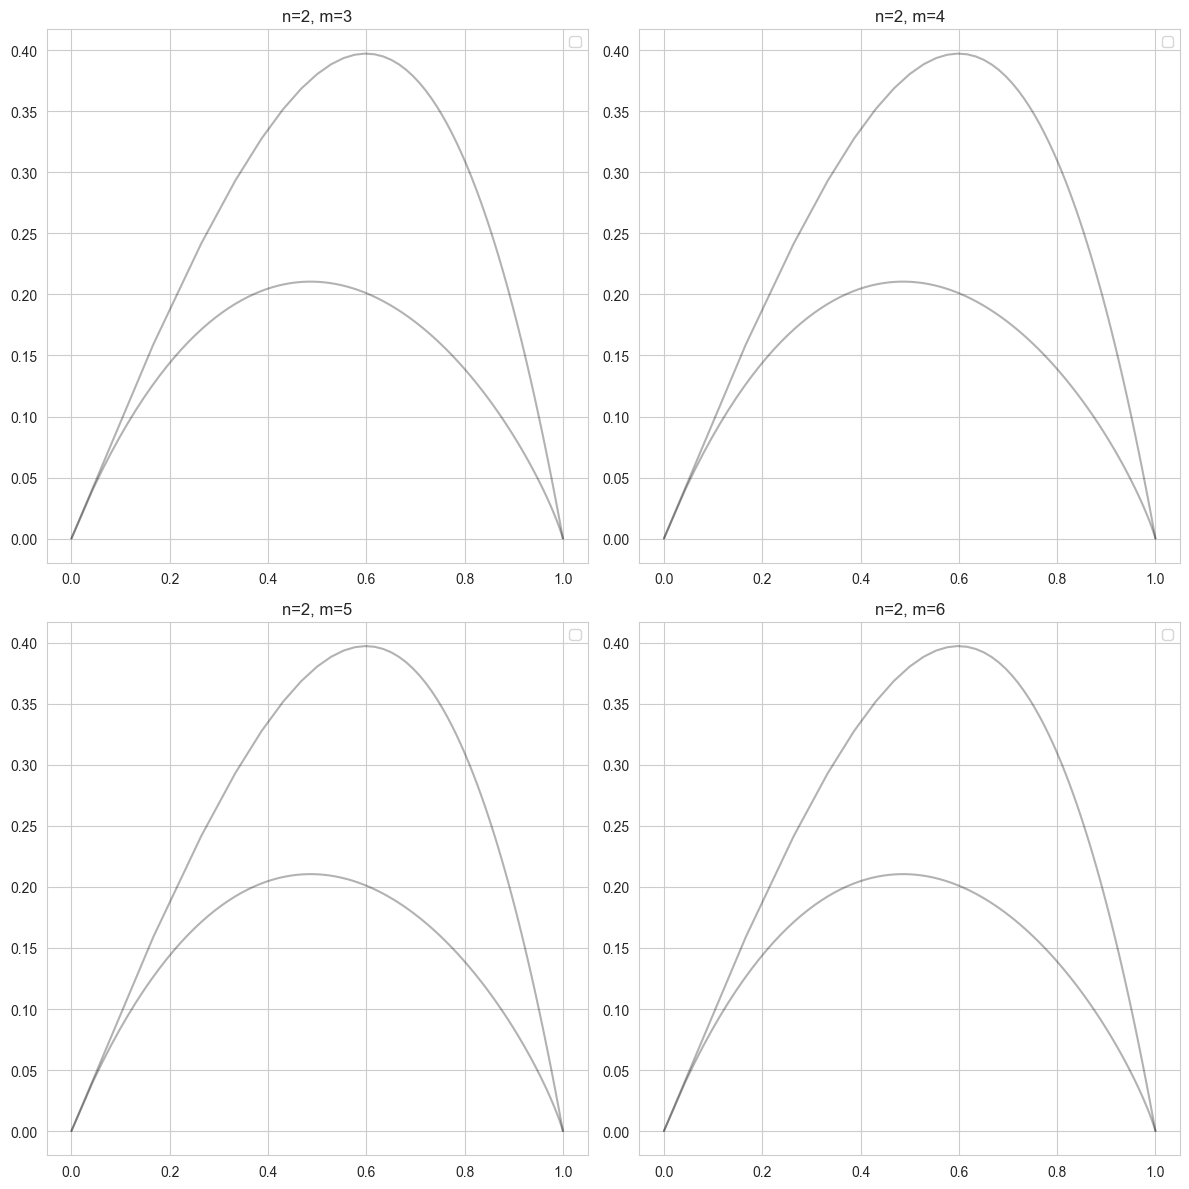

In [9]:
from ordpy import complexity_entropy, minimum_complexity_entropy, maximum_complexity_entropy
n = 2

borders_precomp = {}
for m in [3,4,5,6]:
    borders_precomp[(n, m)] = get_borders(n, m)

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes = axes.flatten()

for m_idx, m in enumerate([3,4,5,6]):
    ax = axes[m_idx]

    min_ec, max_ec = borders_precomp[(n, m)]
    
    sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
    sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)
    
#     min_ce = minimum_complexity_entropy(dx=m, size=70)
#     max_ce = maximum_complexity_entropy(dx=m, m=70)

#     sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
#     sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)

    ax.set_title(f"n={n}, m={m}")
    ax.legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for m_idx, m in enumerate([3,4,5,6]):
    ax = axes[m_idx]

#     min_ec, max_ec = borders_precomp[(n, m)]
    
#     sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
#     sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)
    
    min_ce = minimum_complexity_entropy(dx=m, size=70)
    max_ce = maximum_complexity_entropy(dx=m, m=70)

    sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
    sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)

    ax.set_title(f"n={n}, m={m}")
    ax.legend()

plt.tight_layout()
plt.show()

/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/1494634487.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/1494634487.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/1494634487.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/1494634487.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

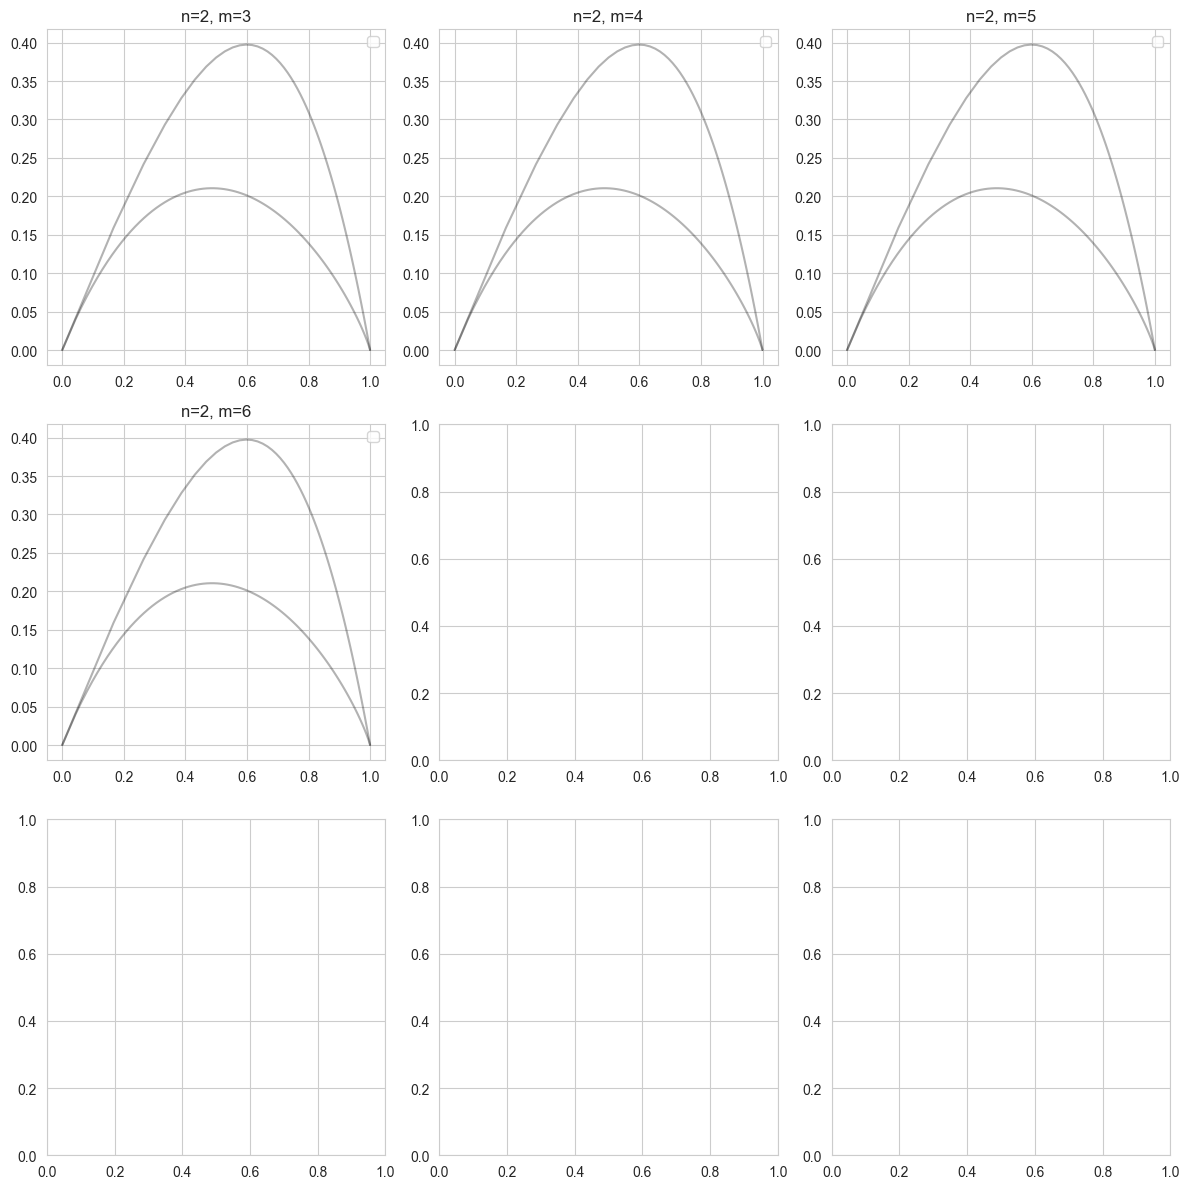

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for m_idx, m in enumerate([3,4,5,6]):
    ax = axes[m_idx]

#     min_ec, max_ec = borders_precomp[(n, m)]
    
#     sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
#     sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)
    
    min_ce = minimum_complexity_entropy(dx=m, size=70)
    max_ce = maximum_complexity_entropy(dx=m, m=70)

    sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
    sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)

    ax.set_title(f"n={n}, m={m}")
    ax.legend()

plt.tight_layout()
plt.show()

/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3954777915.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3954777915.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3954777915.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/3g/4xq9nn556r1b3lm144dhb9400000gn/T/ipykernel_48362/3954777915.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

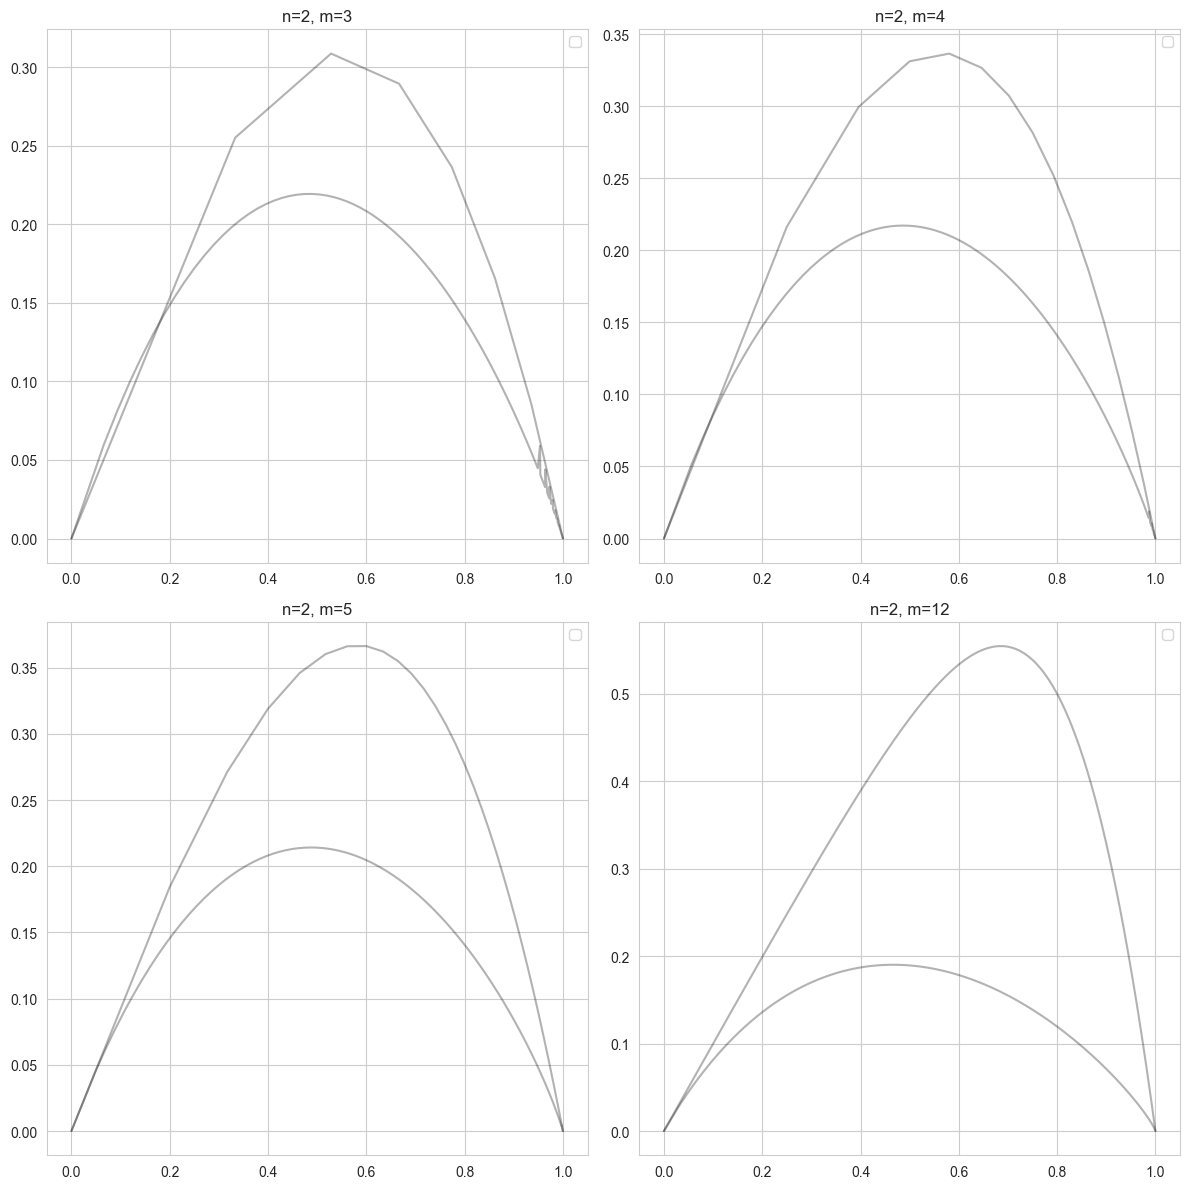

In [11]:
n = 2

borders_precomp = {}
for m in [3,4,5,6, 12]:
    borders_precomp[(n, m)] = get_borders(n, m)

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes = axes.flatten()

for m_idx, m in enumerate([3,4,5,12]):
    ax = axes[m_idx]

    min_ec, max_ec = borders_precomp[(n, m)]
    
    sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
    sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)
    
#     min_ce = minimum_complexity_entropy(dx=m, size=70)
#     max_ce = maximum_complexity_entropy(dx=m, m=70)

#     sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
#     sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)

    ax.set_title(f"n={n}, m={m}")
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
def generate_z_vectors(y, size=5):
    zs = []
    for i in range(len(y)-size):
        zs.append(y[i:i+size])
    return np.array(zs)

def S(p):
    return -np.sum(p * np.log2(p + 10**(-13)))
    
# def complexity_entropy(y, size=5):
#     zs = generate_z_vectors(y,size)
    
    
#     all_patterns = list(permutations(np.arange(size),r=size))
#     freqs = np.zeros(len(all_patterns))
#     n = len(all_patterns)
    
#     patterns, counts = np.unique(np.argsort(zs, axis=1),return_counts=True, axis=0)
    
#     for pattern, count in zip(patterns, counts):
#         freqs[np.all(all_patterns == pattern, axis=1)] = count
    
    
#     P = freqs / np.sum(freqs)
#     Pe = np.full(n, 1/n)
    
#     Smax = np.log2(len(P)) # S(Pe)
    
#     H = S(P)/Smax
    
#     Jmax = -2*(((n+1)/n)*np.log2(n+1) + np.log2(n) - 2*np.log2(2*n))**(-1)
#     J = S((P + Pe)/2) - S(P)/2 - S(Pe)/2
    
#     C = J * H * Jmax
    
#     return H, C


In [17]:
from itertools import permutations
def get_bigrams_with_embeddings(text):
    bigrams = tokenize_and_find_bigrams(text)
    bigrams_with_embeddings = []
    for bigram in bigrams:
        emb1 = get_embedding(bigram[0])
        emb2 = get_embedding(bigram[1])
        if emb1 is not None and emb2 is not None:
            bigram_vector = np.concatenate((emb1, emb2))
            bigrams_with_embeddings.append(bigram_vector)
    return bigrams_with_embeddings

from scipy.spatial.distance import euclidean
def calculate_euclidean_distances_between_bigrams(bigrams):
    distances = []
    for i in range(len(bigrams) - 1):
        bigram1 = bigrams[i]
        bigram2 = bigrams[i + 1]
        distance = euclidean(bigram1, bigram2)
        distances.append(distance)
    
    return distances

def get_embedding(lemma):
    if lemma in embeddings:
        return embeddings[lemma]
    else:
        return None

import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
import re

def tokenize_and_find_bigrams(text):
#     text = re.sub(r'\d+', '', text)
    tokens = nltk.wordpunct_tokenize(text)
    finder = BigramCollocationFinder.from_words(tokens)
    return finder.nbest(BigramAssocMeasures().pmi, len(finder.ngram_fd))

In [58]:
lemma_jokes = open('../lemma_anekdots.txt', 'r').read()[0:1000000]
lemma_liter = open('../lemma_literature.txt', 'r').read()[0:1000000]

bigrams_with_embeddings_jokes = get_bigrams_with_embeddings(lemma_jokes)
distances_series_jokes = calculate_euclidean_distances_between_bigrams(bigrams_with_embeddings_jokes)

bigrams_with_embeddings_liter = get_bigrams_with_embeddings(lemma_liter)
distances_series_liter = calculate_euclidean_distances_between_bigrams(bigrams_with_embeddings_liter)

H_jokes, C_jokes = complexity_entropy(distances_series_jokes, 7)
H_liter, C_liter = complexity_entropy(distances_series_liter, 7)

In [63]:
def split_text_into_chunks(text, chunk_size):
    words = text.split()
    chunks = [' '.join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

chunks_jokes = split_text_into_chunks(lemma_jokes, 25)
chunks_liter = split_text_into_chunks(lemma_liter, 25)

In [64]:
bigrams_with_embeddings_jokes = [get_bigrams_with_embeddings(i) for i in chunks_jokes]
bigrams_with_embeddings_liter = [get_bigrams_with_embeddings(i) for i in chunks_liter]
distances_series_chunks_jokes = [calculate_euclidean_distances_between_bigrams(i) for i in bigrams_with_embeddings_jokes]
distances_series_chunks_liter = [calculate_euclidean_distances_between_bigrams(i) for i in bigrams_with_embeddings_liter]

In [70]:
entropy_jokes = []
complexity_jokes = []
for i in distances_series_chunks_jokes:
    if (len(i)) <= 8:
        continue
#     H, C = entropy_complexity(i, 2, 8)
    H, C = entropy_complexity(np.array(i).reshape(-1, 1), 2, 12)
    entropy_jokes.append(H)
    complexity_jokes.append(C)
    
entropy_liter = []
complexity_liter = []
for i in distances_series_chunks_liter:
    if (len(i)) <= 8:
        continue
    H, C = entropy_complexity(np.array(i).reshape(-1, 1), 2, 12)
    entropy_liter.append(H)
    complexity_liter.append(C)

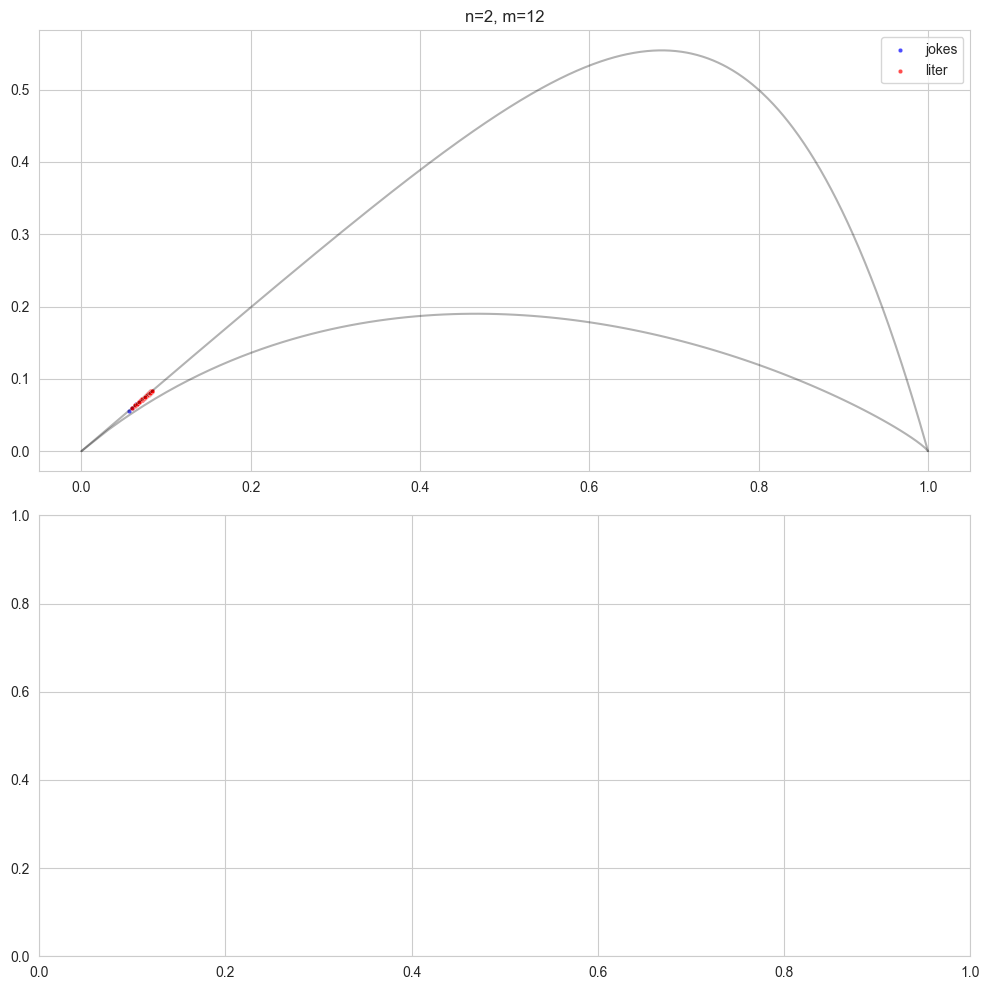

In [71]:
from ordpy import complexity_entropy, minimum_complexity_entropy, maximum_complexity_entropy
n = 2

entropy_jokes

borders_precomp = {}
for m in [12]:
    borders_precomp[(n, m)] = get_borders(n, m)

fig, axes = plt.subplots(2, figsize=(10, 10))

for m_idx, m in enumerate([12]):
    ax = axes[m_idx]

    min_ec, max_ec = borders_precomp[(n, m)]
    
    sns.lineplot(x=min_ec[:, 0], y=min_ec[:, 1], color='black', ax=ax, alpha=0.3)
    sns.lineplot(x=max_ec[:, 0], y=max_ec[:, 1], color='black', ax=ax, alpha=0.3)

    sns.scatterplot(
        x=entropy_jokes,
        y=complexity_jokes,
        color='blue',
        s=10,
        ax=ax,
        alpha=0.7,
        label='jokes'
    )

    sns.scatterplot(
        x=entropy_liter,
        y=complexity_liter,
        color='red',
        s=10,
        ax=ax,
        alpha=0.7,
        label='liter'
    )

    ax.set_title(f"n={n}, m={m}")
    ax.legend()

plt.tight_layout()
plt.show()